In [1]:
import numpy as np

In [1]:
!conda install numba

Solving environment: ...working... done

# All requested packages already installed.



5it [00:07,  1.47s/it]


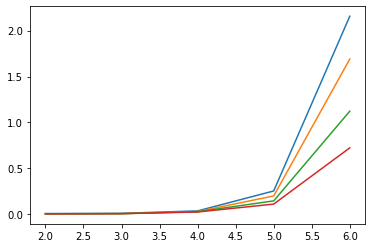

In [7]:
from scipy.spatial import Delaunay
import time, tqdm
import matplotlib.pyplot as plt


ds = [2, 3, 4, 5, 6]
ss = [50, 100, 150, 200, 250, 300, 350]

values = np.zeros((len(ds), len(ss)))

for x, d in tqdm.tqdm(enumerate(ds)):
    for y, i in enumerate(ss):
        dataset = np.random.rand(i, d)
        t = time.time()
        tri = Delaunay(dataset)
        t = time.time() - t
        # print(i, d, t)
        values[x, y] = t
        

plt.plot(ds, values[:, -1], label="350")
plt.plot(ds, values[:, -2], label="300")
plt.plot(ds, values[:, -3], label="250")
plt.plot(ds, values[:, -4], label="200")
plt.show()

In [12]:
from scipy.spatial.distance import  pdist, squareform
import numpy as np

data = np.array([
    [1, 2, 4.0],
    [4, 2, 1.0],
    [0, 0, 0],
    [0, 0, 0]
])
data @ data.T


array([[21., 12.,  0.,  0.],
       [12., 21.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

gamma-Observable Neighbour Graph
https://stackoverflow.com/a/57890082 - based on this answer

In [13]:
import numpy as np
import networkx as nx
import bisect
from numba import jit
from numba import typed, types
import time

import tqdm

def get_complete(dataset):
    dists = dataset @ dataset.T
    graph = nx.Graph()
    graph.add_nodes_from(range(len(dataset)))
    for a in tqdm.tqdm(range(len(dataset))):
        for b in range(a + 1, len(dataset)):
            graph.add_edge(a, b, weight=dists[a, b])
    return graph


@jit
def get_gabriel_numba(dists, result):
    # result = typed.List()
    for a in range(len(dists)):
        for b in range(len(dists)):
            if a == b: continue
            ab = dists[a, b]
            is_gabriel = True
            for c in range(len(dists)):
                if a == c or b == c: continue
                ac = dists[a, c]
                if ac < ab:
                    is_gabriel = False
                    break
            if is_gabriel:
                l = typed.List.empty_list(types.int64, 2)
                l.append(a)
                l.append(b)
                result.append(l)
    return result


def get_gabriel_fast(dataset):
    dists = dataset @ dataset.T
    small = typed.List()
    small.append(0)
    result = typed.List()
    result.append(small)
    result.pop()
    get_gabriel_numba(dataset, result)
    graph = nx.Graph()
    graph.add_weighted_edges_from([(kv[0], kv[1], dists[kv[0], kv[1]]) for kv in result])
    return graph
    

def get_gabriel(dataset):
    dists = dataset @ dataset.T
    graph = nx.DiGraph()
    graph.add_nodes_from(range(len(dataset)))
    for a in tqdm.tqdm(range(len(dataset))):
        dist_idx = np.argsort(dists[a, :])
        for b in dist_idx:
            if a == b: continue
            ab = dists[a, b]
            first_greater = bisect.bisect_left(dists[a, dist_idx], ab)
            is_gabriel = True
            for c in dist_idx[:first_greater]:
                if a == c or b == c: continue
                ac = dists[a, c]
                if ac < ab:
                    is_gabriel = False
                    break
            if is_gabriel:
                graph.add_edge(a, b, weight=ab)
    return graph


# kernel dies after this number for numba implementation
data = np.random.rand(1000, 52)

get_gabriel_fast(data[:10])
print("COMPILED!!!!")

t = time.time()
get_gabriel_fast(data[:100])
t = time.time() - t
print("Numba time for 100", t)


t = time.time()
get_gabriel(data[:100])
t = time.time() - t
print("Python time for 100", t)

# 9 min for 1000
# 72 min for 2000
# 540-620 min for 4000
t = time.time()
G = get_gabriel_fast(data)
t = time.time() - t
print("Woooof", t)

print(f"Graph (V, E) = {len(G), len(G.edges)}")

# t = time.time()
# G = get_gabriel(data)
# t = time.time() - t
# print("Woooof no numba", t)

100%|██████████| 100/100 [00:00<00:00, 1498.62it/s]

COMPILED!!!!
Numba time for 100 0.0019583702087402344
Python time for 100 0.0688161849975586
Woooof 0.13064980506896973
Graph (V, E) = (1000, 4053)


In [14]:
import networkx as nx

labels = [0, 1] * (len(G) // 2) 

Gf = get_gabriel_fast(data[:100]) 
print(f"Graph (V, E) = {len(Gf), len(Gf.edges)}")

G = get_gabriel(data[:100])
print(f"Graph (V, E) = {len(G), len(G.edges)}")

def get_cut(graph, labels):
    return [e for e in G.edges.data("weight", default=None) if labels[e[0]] != labels[e[1]]]



cut = get_cut(G, labels)
print(len(cut))

100%|██████████| 100/100 [00:00<00:00, 868.08it/s]

Graph (V, E) = (100, 100)
Graph (V, E) = (100, 100)
46
